In [1]:
from keras.applications.vgg16 import VGG16
#モデルの準備
model = VGG16(weights = 'imagenet')
model.summary()

Using TensorFlow backend.
C:\Users\kouki\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kouki\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kouki\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kouki\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

C:\Users\kouki\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kouki\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kouki\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kouki\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions
import numpy as np

img_path = 'elephant.jpg'
img = image.load_img(img_path,target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis = 0)
x = preprocess_input(x)

In [3]:
preds =model.predict(x)
print('predicted:',decode_predictions(preds,top = 3)[0])
print(np.argmax(preds[0]))


predicted: [('n02504458', 'African_elephant', 0.7661949), ('n01871265', 'tusker', 0.15761943), ('n02504013', 'Indian_elephant', 0.0760921)]
386


In [38]:
import keras.backend as K
african_elephant_output = model.output[:,386]
last_conv_layer = model.get_layer('block5_conv3')
#各ピクセルによる出力の勾配の計算
grads = K.gradients(african_elephant_output,last_conv_layer.output)[0]
print(grads.shape)
#縦横奥に平均を取る
pooled_grads = K.mean(grads,axis = (0,1,2))
print('layer',pooled_grads.shape)
print('out',last_conv_layer.output[0].shape)
iterate = K.function([model.input],[pooled_grads,last_conv_layer.output[0]])
pooled_grads_value,conv_layer_output_value = iterate([x])
print(pooled_grads_value.shape)
print(conv_layer_output_value.shape)
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(heatmap.shape)

(?, 14, 14, 512)
layer (512,)
out (14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


(14, 14)


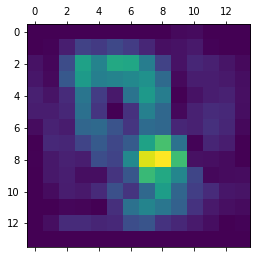

In [5]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap,0)
print(heatmap.shape)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [6]:
import cv2
img = cv2.imread(img_path)
print(heatmap.shape)
print(img.shape)
heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
print(heatmap.shape)
#print(heatmap.shape)
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
superimosed_img = heatmap*0.4 + img
cv2.imwrite('heatmap.jpg',superimosed_img)

(14, 14)
(720, 1082, 3)
(720, 1082)


True

In [7]:
print(superimosed_img.shape)

(720, 1082, 3)


In [33]:
output = model.output[:,386]
print(output.shape)

(?,)


In [22]:
grads = K.gradients(african_elephant_output,last_conv_layer.output)
print(grads[0].shape)

(?, 14, 14, 512)


In [30]:
pooled_grads = K.mean(grads,axis = 2)
print(pooled_grads.shape)

(?, 14, 512)
